In [1]:
# Setup
# ! sudo apt install -y libgl1-mesa-glx libglib2.0-0 libsm6 libxrender1 libxext6
# ! pip install open-iris==1.0.0 faiss-cpu seaborn

# Imports and Functions

## Imports and Constants

In [2]:
import os
import pickle
import shutil
import sys
import threading
import time
from datetime import datetime
from functools import reduce
from io import BytesIO
from itertools import combinations, product
from operator import mul

In [3]:
import boto3
import iris
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import psutil
import scipy
import seaborn as sns
from joblib import Parallel, delayed, parallel_backend
from scipy.spatial.distance import hamming
from scipy.stats import ks_2samp, ttest_ind

In [4]:
import hnsw
from iris.io.dataclasses import IrisTemplate
from iris_integration import (
    iris_with_noise,
    irisint_make_query as make_query,
    irisint_query_to_vector as query_to_vector,
    irisint_distance as distance,
    int_distance
)
from iris_pairwise_min_dist_calculation import get_pairwise_min_dist_across_rotations

In [5]:
n_jobs = 6 # Fit to CPU
DIM = (2, 32, 200)

## General Functions

In [6]:
last_update_time = time.time()
def print_progress(msg, delay=1, force_print=False):
    global last_update_time
    if (time.time() - last_update_time > delay) or force_print:
        sys.stdout.write('\r' + ' ' * (shutil.get_terminal_size().columns - 1))
        sys.stdout.write(f"\r{msg}")
        sys.stdout.flush()
        
        last_update_time = time.time()

def save_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)
    print(f"Object successfully saved to {filename}")

def load_pickle(filename):
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    print(f"Object successfully loaded from {filename}")
    return obj

In [7]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [8]:
def int_to_scaled_string(n):
    suffixes = ['', 'K', 'M', 'B', 'T']
    idx = max(0, min(len(suffixes) - 1, int((len(str(abs(n))) - 1) / 3)))
    scaled = n / (1000 ** idx)
    return f"{scaled:.1f}{suffixes[idx]}" if scaled % 1 else f"{int(scaled)}{suffixes[idx]}"

## Loading Functions

In [9]:
def read_partial_file(filename, num_bits):
    num_bytes = (num_bits + 7) // 8  # Ensure we round up if num_bits isn't a multiple of 8
    with open(filename, 'rb') as f:
        chunk = f.read(num_bytes)
    return np.frombuffer(chunk, dtype=np.uint8)

In [10]:
def load_and_reshape_masks(filename, num_masks, DIM=DIM):
    flattened_data = np.unpackbits(read_partial_file(filename, ((DIM[1]//2) * DIM[2]) * num_masks))
    boolean_arrays = flattened_data.reshape((num_masks, DIM[1]//2, DIM[2]))
    vertically_stacked = np.tile(boolean_arrays, (1, 2, 1))
    duplicated_arrays = np.repeat(vertically_stacked[:, np.newaxis, :, :], DIM[0], axis=1)
    return duplicated_arrays

In [11]:
def load_and_reshape_irises(path_low, path_high, num_samples, DIM=DIM):
    low_high_lst = [
        np.unpackbits(
            read_partial_file(path, (reduce(mul, DIM[1:]) * num_samples)), bitorder="little"
        ).reshape(num_samples, *DIM[1:]) for path in [path_low, path_high]
    ]
    return np.concatenate(low_high_lst, axis=1).astype(bool)

## Test Functions and DB Buildup 

In [12]:
def update_db(db, iris_df, db_size):
    db_current_size = db.get_stats()['db_size']
    assert (db_size - db_current_size) > 0
    
    new_irises = iris_df.loc[range(db_current_size, db_size), 'Template']
    for i, iris in enumerate(new_irises):
        db.insert(make_query(iris))
    iris_df.loc[range(db_current_size, db_size), 'Inserted'] = True

In [13]:
def numpy_array_to_iris_df(iris_array, mask_array):
    def create_iris_template(matrix, mask):
        return IrisTemplate(
            iris_codes=matrix,
            mask_codes=mask, 
            # iris_code_version="v3.0" # Doesn't work on open-iris==1.0.0
        )
    iris_templates = Parallel(n_jobs=n_jobs)(delayed(create_iris_template)(list(iris), list(mask)) for iris, mask in zip(iris_array, mask_array))
    return pd.DataFrame({'Template': iris_templates}).assign(Inserted = False)

In [14]:
def run_single_experiment(db, idx, iris, noise, efSearch, K):
    noisy_query = make_query(iris_with_noise(iris, noise_level=noise))
    res = db.search(noisy_query, K, ef=efSearch)
    return any(idx == tup[1] for tup in res)

# Data Loading

## Configurations

In [36]:
synthetic_data_size = 2**22
max_tested_db_size = 100000

In [39]:
path_masks = f'synthetic_data/{int_to_scaled_string(synthetic_data_size)}_mask_arrays.dat'
path_iris_low = 'synthetic_data/2_23_voter_arrays_90k_b090.dat'
path_iris_high = 'synthetic_data/2_23_voter_arrays_14k_b010.dat'

## Loading

In [40]:
loaded_masks = load_and_reshape_masks(path_masks, max_tested_db_size).astype(bool)
loaded_irises = load_and_reshape_irises(path_iris_low, path_iris_high, max_tested_db_size)

## Reassuring stats

In [41]:
assert len(loaded_masks) == max_tested_db_size
assert len(loaded_irises) == max_tested_db_size
print(f'Successfuly loaded {int_to_scaled_string(max_tested_db_size)} masks and irises')

Successfuly loaded 100K masks and irises


# Search Analysis

## Configurations

In [56]:
M_range = np.arange(16, 65, 8)
db_size_range = np.arange(1000, 100001, 1000)
K = 1

In [57]:
assert db_size_range.max() <= max_tested_db_size

In [58]:
num_experiments = 1000
noise_level = 0.2

## Precision Testing

In [ ]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(max_tested_db_size, *DIM), loaded_masks)
db = hnsw.HNSW(
    M=M, 
    efConstruction=efConstruction, 
    m_L=1/np.log(M), 
    distance_func=distance, 
    query_to_vector_func=query_to_vector
)

In [16]:
for i, db_size in enumerate(db_size_range):
    # Progress Update
    print_progress(f'Test progress: {((i+1)/len(db_size_range)):.1%}, currently building and testing db size {int_to_scaled_string(db_size)}')

    # DB Build up
    update_db(db, iris_df, db_size)

    # Precision testing
    indices, irises = iris_df.loc[iris_df['Inserted'], 'Template'].sample(num_experiments).reset_index().T.values
    with parallel_backend('threading'):
        results = Parallel(n_jobs=n_jobs)(
            delayed(run_single_experiment)(db, indices[i], irises[i], noise_level, efSearch, K) for i in range(num_experiments)
        )
    precision_lst.append((db_size, np.mean(results)))

## Search-log Testing

In [351]:
def process_search_log(search_log):
    search_log_df = pd.DataFrame(search_log, index=['step', 'depth', 'eq', 'fq', 'lc', 'entry_point']).T.reset_index().rename(columns={'index':'node_id'})
    search_log_df['total_num_steps'] = len(search_log_df)
    search_log_df = search_log_df[search_log_df['step'] <= search_log_df['eq'].argmin()]
    search_log_df['step'], search_log_df['depth'] = search_log_df['step'].astype(int), search_log_df['depth'].astype(int)
    search_log_df['search_progress'] = search_log_df['eq'].cummin()
    search_log_df['single_step_progress'] = search_log_df['search_progress'].diff(periods=-1)
    return search_log_df

In [ ]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(max_tested_db_size, *DIM), loaded_masks)

In [352]:
num_experiments, df_list = 1000, []
for M in [16, 32, 64]:
    db = hnsw.HNSW(
        M=M, 
        efConstruction=efConstruction, 
        m_L=1/np.log(M), 
        distance_func=distance, 
        query_to_vector_func=query_to_vector
    )
    for only_layer_0 in [False, True]:
        if only_layer_0: 
            db.layers = [db.layers[0]]
        for efSearch in np.arange(8, 81, 8):
            indices, irises = iris_df.loc[iris_df['Inserted'], 'Template'].sample(num_experiments).reset_index().T.values            
            precision_lst = []
            for i in range(num_experiments):
                print_progress(f'M={M}, Layer 0={only_layer_0}, efSearch={efSearch}, Search progress: {(i+1)/(num_experiments+1):.1%}')
                noisy_query = make_query(iris_with_noise(irises[i], noise_level=0.2))
                res = db.search(noisy_query, 1, ef=efSearch)
                precision_lst.append(any(indices[i] == tup[1] for tup in res))

                df_list.append(
                    process_search_log(db.search_log).assign(
                        experiment = i,
                        M = M,
                        only_layer_0 = only_layer_0,
                        efSearch = efSearch,
                        FNMR = np.mean(precision_lst),
                        target_node_id = indices[i],
                    )
                )
final_df = pd.concat(df_list, ignore_index=True)

M=64, Layer 0=False, efSearch=128, Search progress: 99.9%

In [304]:
plot_df = final_df.groupby(['M', 'efSearch', 'only_layer_0', 'experiment'])['FNMR'].first().reset_index()
plot_df.rename(columns={'only_layer_0':'Only Layer 0'}, inplace=True)
plot_df['FNMR'] = 1 - plot_df['FNMR']

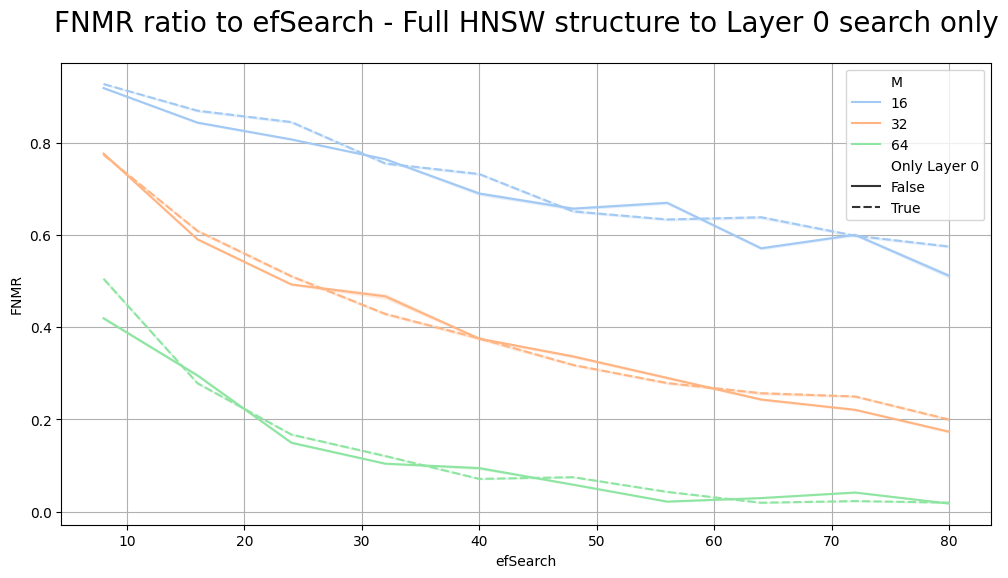

In [347]:
plt.figure(figsize=(12,6))
sns.lineplot(plot_df, x='efSearch', y='FNMR', hue='M', palette='pastel', style='Only Layer 0')
plt.grid()
plt.title('FNMR ratio to efSearch - Full HNSW structure to Layer 0 search only', fontsize=20, y=1.05)
plt.show()

In [389]:
def add_curr_source_node(group):
    sources = np.where(group['single_step_progress'].shift() > 0, group['node_id'], np.nan)
    return pd.Series(data=sources, index=group.index).ffill()

In [423]:
def get_single_experiment_distances_df(group):
    distances_df_lst = []
    for index, (experiment, curr_source_node, target_node_id, depth) in group.iterrows():
        source_neighbors = [tup[1] for tup in db.layers[0][int(curr_source_node)]]
        distances = [int_distance(db.vectors[int(target_node_id)], db.vectors[neighbor]) for neighbor in source_neighbors]
        distances_df_lst.append(pd.DataFrame({'Distances':distances, 'Depth':depth}))
    return pd.concat(distances_df_lst)

In [ ]:
final_df['curr_source_node'] = final_df.groupby('experiment', group_keys=False).apply(add_curr_source_node)
progress_df = final_df[final_df['lc'] == 0].groupby(['experiment', 'curr_source_node'], sort=False)['target_node_id'].first().reset_index()
progress_df['depth'] = progress_df.groupby('experiment').cumcount()

In [15]:
distances_df = progress_df.groupby('experiment').apply(get_single_experiment_distances_df).droplevel(1).reset_index()
distances_df = distances_df[distances_df['Distances'] > 0]
distances_df['Depth'] = distances_df['Depth'].astype(int)

In [499]:
depth_hist_df = distances_df.drop(columns='Distances').drop_duplicates().reset_index(drop=True)
depth_hist_df = depth_hist_df.groupby('experiment')['Depth'].max()

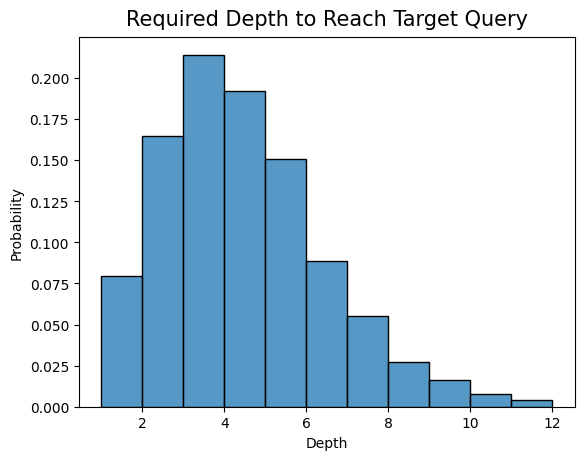

In [503]:
sns.histplot(depth_hist_df, stat='probability', bins=11)
plt.title(f'Required Depth to Reach Target Query', fontsize=15, y=1.01)
plt.show()

In [ ]:
def plot_hist_with_stats(data, **kwargs):
    sns.histplot(data, x="Distances", stat="probability", kde=True, **kwargs)
    mean, std = data["Distances"].mean(), data["Distances"].std()
    depth = data['Depth'].iloc[0]
    plt.gca().set_title(f"Depth = {depth}\nMean: {mean:.2f}, Std: {std:.2f}")

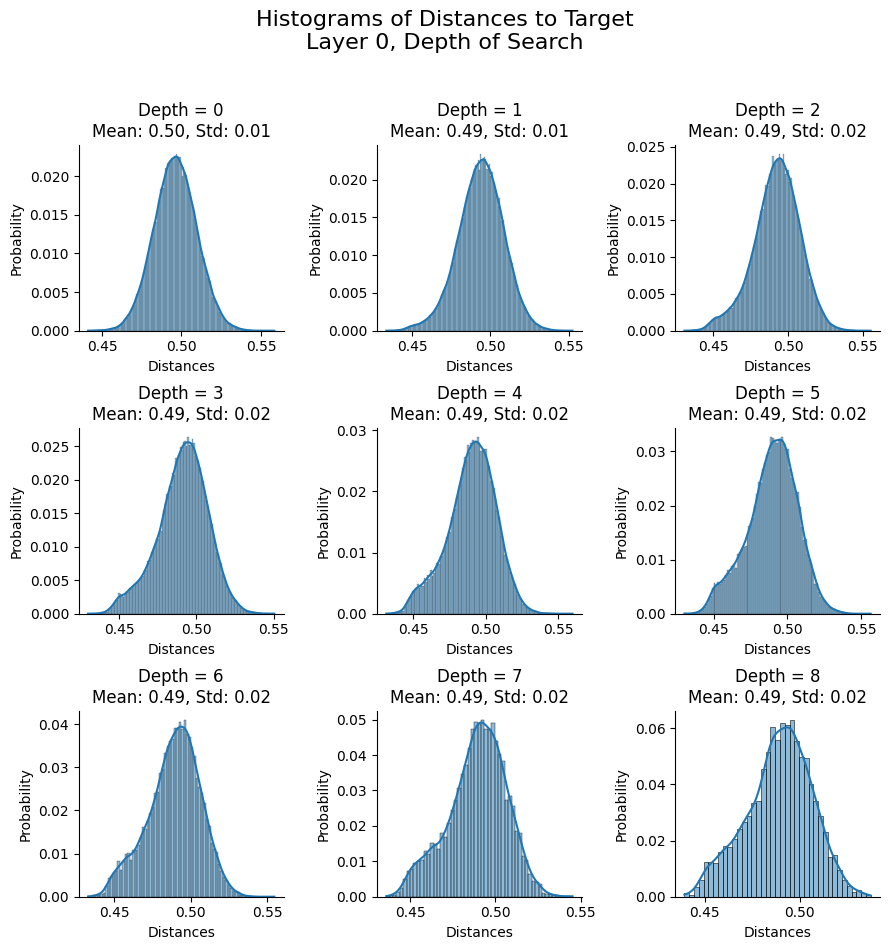

In [492]:
facetgrid = sns.FacetGrid(distances_df[distances_df['Depth'] <= 8], col="Depth", col_wrap=3, height=3, sharex=False, sharey=False)
facetgrid.map_dataframe(plot_hist_with_stats)
facetgrid.fig.suptitle("Histograms of Distances to Target\nLayer 0, Depth of Search", fontsize=16, y=1.05)
plt.subplots_adjust(top=0.9)
plt.show()